Number of healthy leaf images in training set 458
Number of powder leaf images in training set 430
Number of rusty leaf images in training set 434
Number of healthy leaf images in test set 50
Number of powder leaf images in test set 50
Number of rusty leaf images in test set 50
Number of healthy leaf images in validation set 20
Number of powder leaf images in validation set 20
Number of rusty leaf images in validation set 20
Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Epoch 1/5
42/42 [==============================] - 1933s 45s/step - loss: 1.3264 - accuracy: 0.5045 - val_loss: 0.7097 - val_accuracy: 0.6333
Epoch 2/5
42/42 [==============================] - 405s 10s/step - loss: 0.7374 - accuracy: 0.6581 - val_loss: 0.6204 - val_accuracy: 0.7333
Epoch 3/5
42/42 [==============================] - 391s 9s/step - loss: 0.6350 - accuracy: 0.7179 - val_loss: 0.6772 - val_accuracy: 0.6833
Epoch 4/5
42/42 [==============================] - 406s 10s/step -

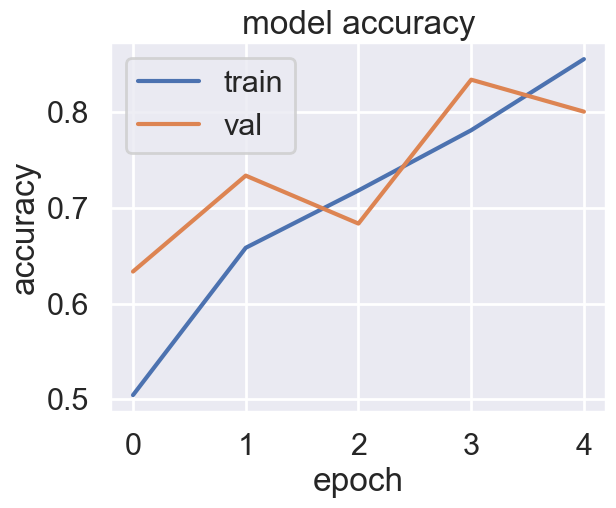

C:\Users\hp\AppData\Local\Temp\ipykernel_5456\4071575469.py:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((200, 200), Image.ANTIALIAS)


1/1 [==============================] - 0s 78ms/step


In [ ]:
import os
import time
import tkinter as tk
from tkinter import filedialog
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from PIL import Image, ImageTk
import IPython.display as display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from matplotlib import pyplot as plt
import seaborn as sns

def total_files(folder_path):
    num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    return num_files

def preprocess_image(image_path, target_size=(225, 225)):
    img = load_img(image_path, target_size=target_size)
    x = img_to_array(img)
    x = x.astype('float32') / 255.
    x = np.expand_dims(x, axis=0)
    return x

def display_image(image_path):
    img = Image.open(image_path)
    img = img.resize((200, 200), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)
    image_label.config(image=img)
    image_label.image = img

def predict():
    filename = filedialog.askopenfilename(initialdir="/", title="Select Image",
                                          filetypes=(("Image files", "*.jpg *.jpeg *.png"), ("all files", "*.*")))
    if filename:
        display_image(filename)
        # Start time for prediction
        prediction_start_time = time.time()
        
        x = preprocess_image(filename)
        predictions = model.predict(x)
        predicted_label = labels[np.argmax(predictions)]
        
        # End time for prediction
        prediction_end_time = time.time()
        
        # Calculate prediction time
        prediction_time = prediction_end_time - prediction_start_time
        
        # Update the result label with predicted disease and prediction time
        result_label.config(text="Predicted disease: " + predicted_label + "\nPrediction time: {:.2f} seconds".format(prediction_time))
    else:
        result_label.config(text="No file selected")

train_files_healthy = "Train/Train/Healthy"
train_files_powdery = "Train/Train/Powdery"
train_files_rust = "Train/Train/Rust"

test_files_healthy = "Test/Test/Healthy"
test_files_powdery = "Test/Test/Powdery"
test_files_rust = "Test/Test/Rust"

valid_files_healthy = "Validation/Validation/Healthy"
valid_files_powdery = "Validation/Validation/Powdery"
valid_files_rust = "Validation/Validation/Rust"

print("Number of healthy leaf images in training set", total_files(train_files_healthy))
print("Number of powder leaf images in training set", total_files(train_files_powdery))
print("Number of rusty leaf images in training set", total_files(train_files_rust))

print("========================================================")

print("Number of healthy leaf images in test set", total_files(test_files_healthy))
print("Number of powder leaf images in test set", total_files(test_files_powdery))
print("Number of rusty leaf images in test set", total_files(test_files_rust))

print("========================================================")

print("Number of healthy leaf images in validation set", total_files(valid_files_healthy))
print("Number of powder leaf images in validation set", total_files(valid_files_powdery))
print("Number of rusty leaf images in validation set", total_files(valid_files_rust))

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('Train/Train',
                                                    target_size=(225, 225),
                                                    batch_size=32,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory('Validation/Validation',
                                                        target_size=(225, 225),
                                                        batch_size=32,
                                                        class_mode='categorical')

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(225, 225, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Start time for training
training_start_time = time.time()

history = model.fit(train_generator,
                    batch_size=16,
                    epochs=5,
                    validation_data=validation_generator,
                    validation_batch_size=16)

# End time for training
training_end_time = time.time()

# Calculate training time
training_time = training_end_time - training_start_time
print("Training Time: {:.2f} seconds".format(training_time))

# Plotting accuracy
sns.set_theme()
sns.set_context("poster")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

model.save("model.h5")

# Load the model for prediction
model = load_model("model.h5")
labels = {0: 'Healthy', 1: 'Powdery', 2: 'Rust'}  # Define your class labels here

# Create main window
root = tk.Tk()
root.title("Leaf Disease Prediction")

# Create widgets
title_label = tk.Label(root, text="Leaf Disease Prediction", font=("Helvetica", 16))
title_label.pack(pady=10)

browse_button = tk.Button(root, text="Browse", command=predict)
browse_button.pack(pady=5)

image_label = tk.Label(root)
image_label.pack()

result_label = tk.Label(root, text="", font=("Helvetica", 12))
result_label.pack(pady=5)

# Run the application
root.mainloop()
